## 1. Import data

In [1]:
import pandas as pd
data_path = 'data/central_west.csv'
df = pd.read_csv(data_path)

In [20]:
df.head()

,index,Data,Hora,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),...,"VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",region,state,station,station_code,latitude,longitude,height
0,138998,2017-12-20,14:00,0.0,899.6,900.0,899.6,3391,26.5,17.7,...,39,9.6,3.9,CO,DF,PARANOA (COOPA-DF),A047,-16.011111,-47.5575,1043.0
1,138999,2017-12-20,15:00,0.0,899.2,899.6,899.2,3306,26.6,16.7,...,55,8.3,3.4,CO,DF,PARANOA (COOPA-DF),A047,-16.011111,-47.5575,1043.0
2,139000,2017-12-20,16:00,0.0,898.6,899.2,898.6,3167,27.3,15.8,...,62,8.3,3.6,CO,DF,PARANOA (COOPA-DF),A047,-16.011111,-47.5575,1043.0
3,139001,2017-12-20,17:00,0.0,897.7,898.6,897.7,3279,27.5,12.9,...,43,6.7,3.1,CO,DF,PARANOA (COOPA-DF),A047,-16.011111,-47.5575,1043.0
4,139002,2017-12-20,18:00,0.0,897.0,897.7,897.0,2753,27.5,13.7,...,98,6.4,3.5,CO,DF,PARANOA (COOPA-DF),A047,-16.011111,-47.5575,1043.0


## 2. Clean data, fill missing values:

#### Fill missing values:

In [2]:
import numpy as np

metadata = pd.read_csv('data/columns_description.csv')
abbreviation = metadata.abbreviation
pd.options.mode.chained_assignment = None

def process_raw(df):
    """
    ! drop index
    ! rename the columns
    ! combine hour and date columns -> transform to date_time
    ! append columns data from all stations to keep the data granularity
    ! remove unimportant columns
    ! return table 
    """
    df.drop(['index'],inplace=True, axis=1)
    df.columns = abbreviation
    df.drop(['regi','prov','wsnm','lat','lon','elvt'], inplace=True, axis=1)
    return df

def clean_na(df, na_value = -9999):
    """ 
    ! replace Na from dataset
    """
    df = df.replace(to_replace=na_value,value=np.NaN)
    df = df[df.iloc[:,1].first_valid_index():]
    df = df.ffill()
    return df

# minimum date: 2000-05-07
# maximum date: 2021-04-30
def make_dataset(start_date, end_date, df):
    """
    ! filter raw data from date and stations code
    ! process data
    ! clean na
    """
    df = df.loc[(df['Data'] >= start_date) & (df['Data'] <= end_date)]
    df = process_raw(df)
    df = clean_na(df)
    return df.reset_index()

# only take data from 2001-2020 (20 years)
df = make_dataset(start_date='2001-01-01', end_date='2020-12-31', df=df) 

# we only care about hourly observation
df = df[['date', 'hr', 'prcp']]
df['date'] = pd.to_datetime(df['date'])
df.head()

abbreviation,date,hr,prcp
0,2017-12-20,14:00,0.0
1,2017-12-20,15:00,0.0
2,2017-12-20,16:00,0.0
3,2017-12-20,17:00,0.0
4,2017-12-20,18:00,0.0


Because hourly precipitation is very unstable, we only care about daily precipitation

And hourly data is collected at many stations, so at first, we will take the mean value for each hour of day

In [3]:
df = df.groupby(['date', 'hr'], as_index=False)['prcp'].mean()
df.head()

,date,hr,prcp
0,2001-01-01,00:00,0.8
1,2001-01-01,01:00,3.4
2,2001-01-01,02:00,1.4
3,2001-01-01,03:00,0.0
4,2001-01-01,04:00,0.0


In [4]:
df.describe()

,date,prcp
count,175320,175320.000000
mean,2011-01-01 00:00:00,0.159935
min,2001-01-01 00:00:00,0.000000
25%,2006-01-01 00:00:00,0.000000
50%,2011-01-01 00:00:00,0.037431
75%,2016-01-01 00:00:00,0.196429
max,2020-12-31 00:00:00,24.000000
std,NaN,0.331568


In [78]:
for year in range(2001, 2021):
    df[df['date'].dt.year == year].sort_values(['date', 'hr']).to_csv(f'inspection/prcp_{year}_hourly.csv')

In [4]:
#daily precipitation
df = df.groupby(['date'], as_index=False)['prcp'].sum()
df.head()

,date,prcp
0,2001-01-01,34.0
1,2001-01-02,28.4
2,2001-01-03,0.4
3,2001-01-04,7.0
4,2001-01-05,0.0


In [9]:
df.describe()

,date,prcp
count,7305,7305.000000
mean,2011-01-01 00:00:00,3.838448
min,2001-01-01 00:00:00,0.000000
25%,2006-01-01 00:00:00,0.268966
50%,2011-01-01 00:00:00,2.677551
75%,2016-01-01 00:00:00,5.928571
max,2020-12-31 00:00:00,88.200000
std,NaN,4.388333


## 2. Distribution

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_5894/3395390118.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['prcp'] < 40.0]['prcp'], bins = 30, color='blue') # only 3 values proceed 40.0


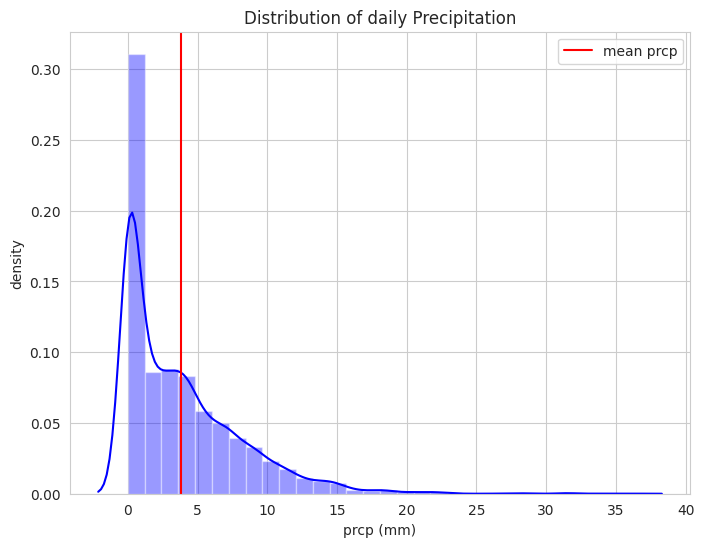

In [29]:
list_prcp = df['prcp'].tolist()
mean_prcp = sum(list_prcp) / len(list_prcp)

# rain_daily
plt.figure(figsize = (8, 6))
sns.distplot(df[df['prcp'] < 40.0]['prcp'], bins = 30, color='blue') # only 3 values proceed 40.0  
plt.axvline(x=mean_prcp, label='mean prcp', c='red')
plt.title('Distribution of daily Precipitation')
plt.legend()
plt.ylabel('density')
plt.xlabel('prcp (mm)')
plt.savefig('graph/rain/prcp_daily_distribution.png')

/tmp/ipykernel_5894/377982734.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rain_monthly['prcp'], bins = 30, color='blue')


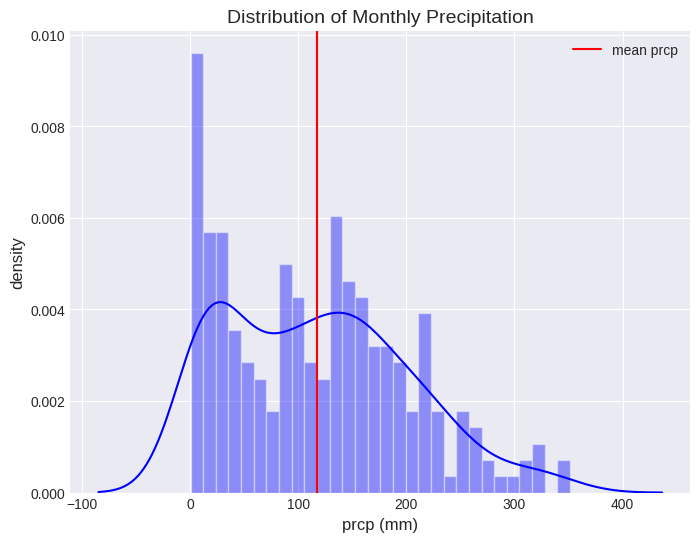

In [54]:
list_prcp = rain_monthly['prcp'].tolist()
mean_prcp = sum(list_prcp) / len(list_prcp)

# rain_daily
plt.figure(figsize = (8, 6))
sns.distplot(rain_monthly['prcp'], bins = 30, color='blue')
plt.axvline(x=mean_prcp, label='mean prcp', c='red')
plt.title('Distribution of Monthly Precipitation')
plt.legend()
plt.ylabel('density')
plt.xlabel('prcp (mm)')
plt.savefig('graph/rain/prcp_monthly_distribution.png')

## 4. Plot time series graph:

In [32]:
# config plotter
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

plt.style.use("seaborn-v0_8-darkgrid")  # Sử dụng theme đẹp
sns.set_palette("Set2")  # Chọn bảng màu đẹp
plt.rcParams["figure.figsize"] = (10, 5)  # Kích thước hình vẽ mặc định
plt.rcParams["axes.labelsize"] = 12  # Cỡ chữ trục
plt.rcParams["axes.titlesize"] = 14  # Cỡ chữ tiêu đề


##### Daily:

In [6]:
df

,date,prcp
0,2001-01-01,34.000000
1,2001-01-02,28.400000
2,2001-01-03,0.400000
3,2001-01-04,7.000000
4,2001-01-05,0.000000
...,...,...
7300,2020-12-27,4.500000
7301,2020-12-28,4.138596
7302,2020-12-29,3.328070
7303,2020-12-30,4.698246


In [34]:
df.to_csv('rainfall_daily.csv', index=False)

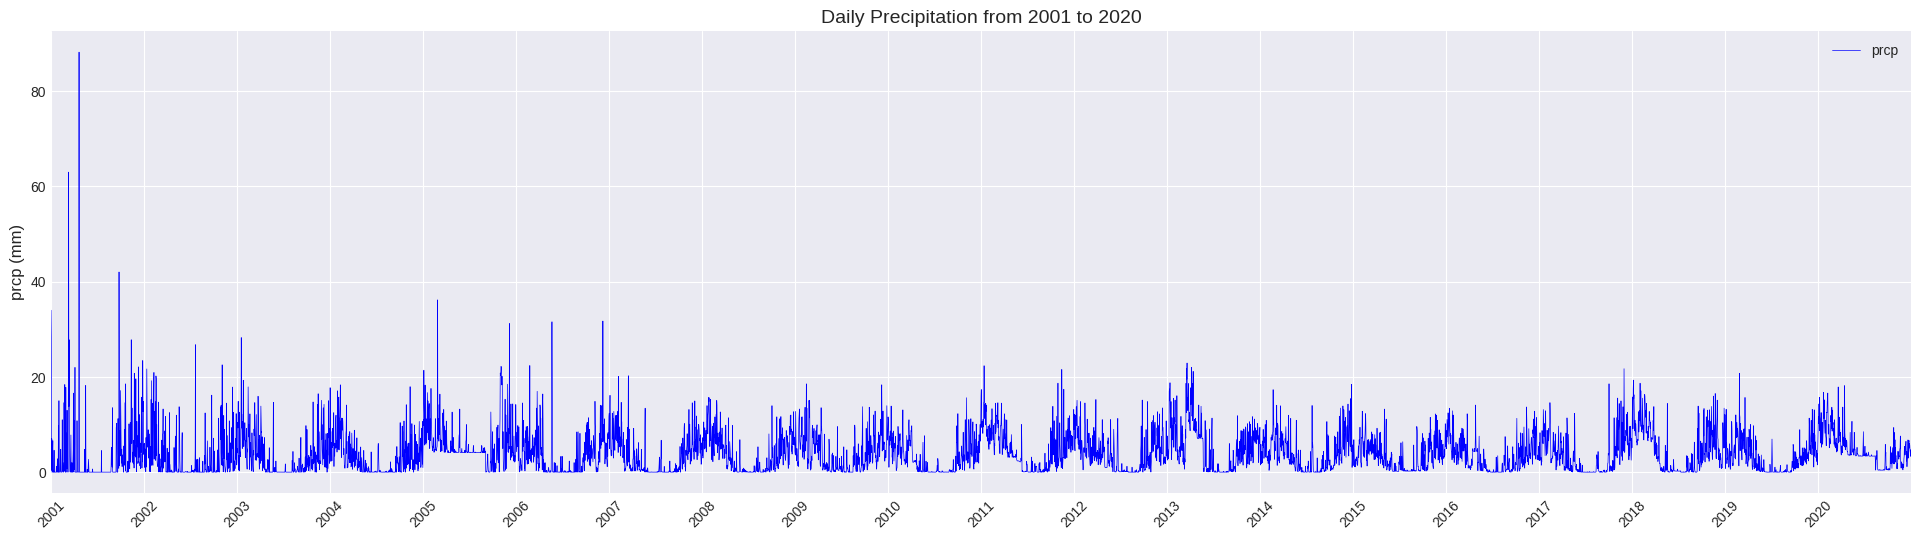

In [51]:
plt.figure(figsize=(24, 6))
sns.lineplot(x=df["date"], y=df["prcp"], label="prcp", color="b", linewidth=0.5)
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator()) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)  
plt.title("Daily Precipitation from 2001 to 2020", fontsize=14)
plt.xlabel(None)
plt.ylabel("prcp (mm)", fontsize=12)
plt.grid(True)
plt.savefig('graph/rain/prcp_daily.png')


##### Monthly:

In [10]:
rain_monthly = df[['date', 'prcp']]
rain_monthly['month'] = pd.to_datetime(rain_monthly['date'].dt.year.astype(str) + '-' + rain_monthly['date'].dt.month.astype(str))
rain_monthly = rain_monthly.groupby(['month'], as_index=False)['prcp'].sum()
rain_monthly

,month,prcp
0,2001-01-01,101.400000
1,2001-02-01,98.200000
2,2001-03-01,201.200000
3,2001-04-01,141.200000
4,2001-05-01,29.233333
...,...,...
235,2020-08-01,68.122807
236,2020-09-01,29.405263
237,2020-10-01,83.208772
238,2020-11-01,76.663158


In [11]:
rain_monthly.to_csv('prcp_monthly.csv', index=True)

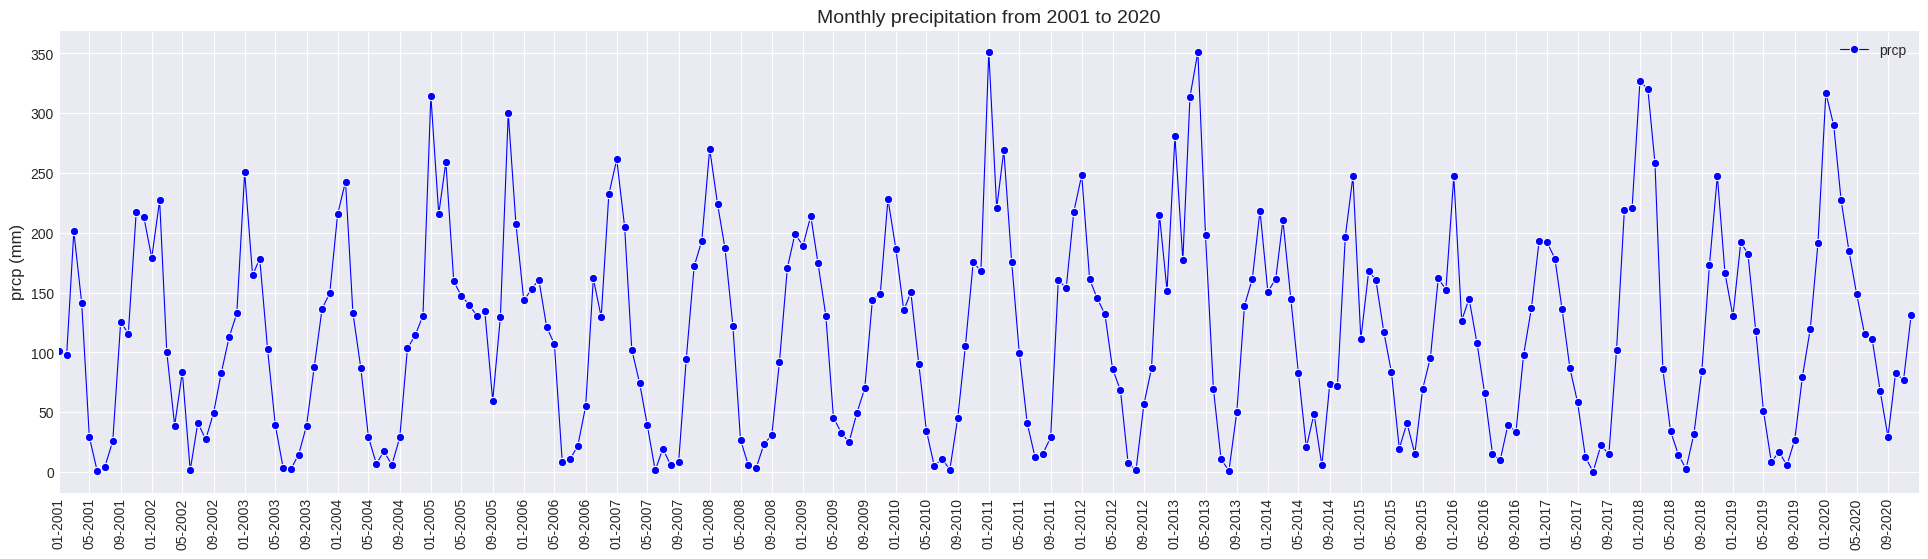

In [46]:
plt.figure(figsize=(24, 6))
sns.lineplot(x=rain_monthly["month"], y=rain_monthly["prcp"], label="prcp", color="b", linewidth=0.8, marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.title("Monthly precipitation from 2001 to 2020", fontsize=14)
plt.xlabel(None)
plt.ylabel("prcp (mm)", fontsize=12)
plt.grid(True)
plt.savefig('graph/rain/prcp_monthly.png')


##### Yearly:

In [48]:
rain_yearly = df[['date', 'prcp']]
rain_yearly['year'] = pd.to_datetime(rain_yearly['date'].dt.year, format='%Y')
rain_yearly = rain_yearly.groupby(['year'], as_index=False)['prcp'].sum()
rain_yearly

,year,prcp
0,2001-01-01,1273.900000
1,2002-01-01,1077.372987
2,2003-01-01,1169.069431
3,2004-01-01,1115.700000
4,2005-01-01,2197.914286
5,2006-01-01,1305.550299
6,2007-01-01,1177.077817
7,2008-01-01,1356.127328
8,2009-01-01,1453.334211
9,2010-01-01,1109.290689


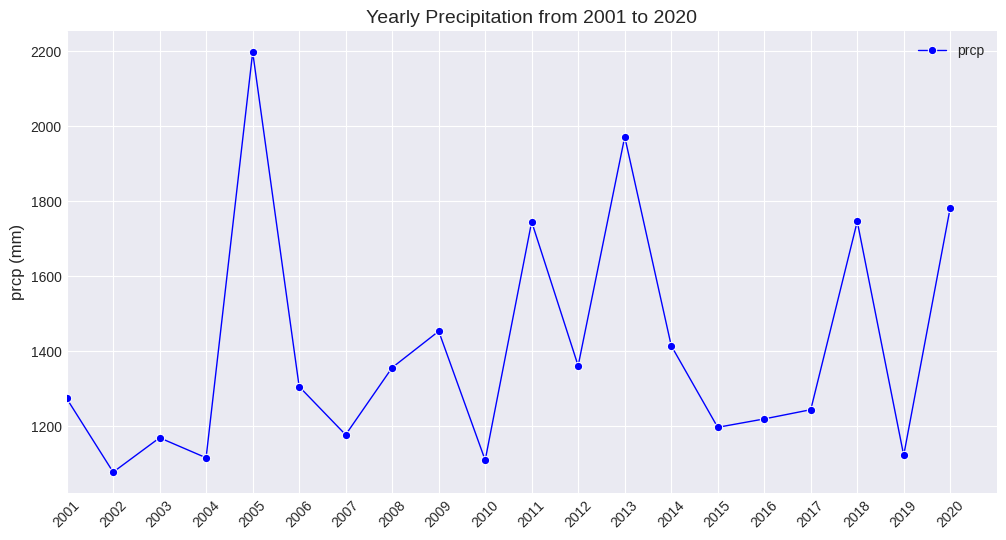

In [49]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=rain_yearly["year"], y=rain_yearly["prcp"], label="prcp", color="b", linewidth=1, marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator()) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)  
plt.title("Yearly Precipitation from 2001 to 2020", fontsize=14)
plt.xlabel(None)
plt.ylabel("prcp (mm)", fontsize=12)
plt.grid(True)
plt.savefig('graph/rain/prcp_yearly.png')